# Processing the data

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py

Using TensorFlow backend.


In [2]:
# Reproducibility
seed = 8 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
physical_devices_cpu = tf.config.experimental.list_physical_devices('CPU')
print('CPUs Available: ' ,len(physical_devices_cpu))
physical_devices_gpu = tf.config.experimental.list_physical_devices('GPU')
print('GPUs Available: ' ,len(physical_devices_gpu))

CPUs Available:  1
GPUs Available:  0


In [4]:
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    dataset = df.values
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[0:10000,0:N_channels+1]
    # channel SNRs
    Y = dataset[0:10000,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scale = min_max_scaler.fit_transform(X)
    Y_scale = min_max_scaler.fit_transform(Y)
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Visualising the Model

In [5]:
def visualising_data(hist):
    plt.title('Mean Squared Error')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_loss'], label='Test')
    plt.legend()
    plt.show()
#     plt.plot(hist.history['mean_absolute_error'], label='Train')
#     plt.plot(hist.history['val_mean_absolute_error'], label='Test')
#     plt.legend()
#     plt.show()

# Building the ANN

In [6]:
def build_model(N_channels, file_path):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = processing_data(N_channels, file_path)
    model = Sequential()
#     kernel_regularizer=regularizers.l2(0.00001)  - ADD THIS AT SOME POINT
    model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l1(0.000001), input_dim=N_channels+1))
    model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l1(0.000001)))
    model.add(Dense(N_channels, activation='sigmoid', kernel_regularizer=regularizers.l1(0.000001)))
    # learning_rate=0.1 causes zig-zags, learning_rate=0.0001 is far too slow
#     opt = keras.optimizers.Adam(learning_rate=0.001)
    opt = 'adam'
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
    # fit as we are fitting the parameters to the data
    # verbose shows how much info is shown during model fitting
    # shuffle by default set to true so this is for visual purposes
    start_time = time.time()
    hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
    training_time = time.time() - start_time
    return hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, training_time

In [7]:
def evaluate_model(N_channels, file_path):
    hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, training_time = build_model(N_channels, file_path)
    visualising_data(hist)
    #0 = loss, 1 = accuracy
    train_mse = (model.evaluate(X_train, Y_train, verbose=1))[1]
    test_mse = (model.evaluate(X_test, Y_test, verbose=1))[1]
    val_mse = (model.evaluate(X_val, Y_val, verbose=1))[1]
    model.save('/Users/jackkelly/Desktop/Building_Model/' + str(N_channels) + '_channels_ANN_model.h5')
    print('MSE train: %.5f, MSE test: %.5f MSE val: %.5f' % (train_mse, test_mse, val_mse))
    print("Training Time: %s" % (training_time))
    return model

(7000, 31) (1500, 31) (1500, 31) (7000, 30) (1500, 30) (1500, 30)
Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - 2s 224us/step - loss: 0.0824 - mean_squared_error: 0.0811 - mean_absolute_error: 0.2411 - val_loss: 0.0335 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1477
Epoch 2/40
7000/7000 [==============================] - 1s 90us/step - loss: 0.0170 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0997 - val_loss: 0.0087 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0694
Epoch 3/40
7000/7000 [==============================] - 1s 90us/step - loss: 0.0056 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0509 - val_loss: 0.0041 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0400
Epoch 4/40
7000/7000 [==============================] - 1s 91us/step - loss: 0.0035 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0349 - val_loss: 0.0031 - val_mean_squared_error: 0.0015 - v

7000/7000 [==============================] - 1s 102us/step - loss: 0.0024 - mean_squared_error: 8.2154e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0024 - val_mean_squared_error: 7.7549e-04 - val_mean_absolute_error: 0.0208
Epoch 36/40
7000/7000 [==============================] - 1s 101us/step - loss: 0.0024 - mean_squared_error: 8.3870e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0024 - val_mean_squared_error: 8.0919e-04 - val_mean_absolute_error: 0.0218
Epoch 37/40
7000/7000 [==============================] - 1s 102us/step - loss: 0.0024 - mean_squared_error: 8.2525e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0023 - val_mean_squared_error: 7.1990e-04 - val_mean_absolute_error: 0.0198
Epoch 38/40
7000/7000 [==============================] - 1s 104us/step - loss: 0.0024 - mean_squared_error: 7.8195e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0024 - val_mean_squared_error: 8.5112e-04 - val_mean_absolute_error: 0.0224
Epoch 39/40
7000/7000 [==============================] -

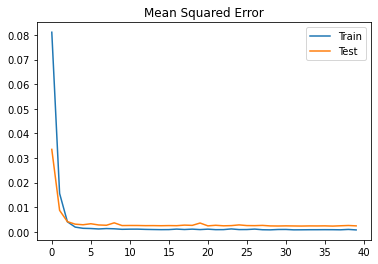

1500/1500 [==============================] - 0s 34us/step
MSE train: 0.00076, MSE test: 0.00081 MSE val: 0.00082
Training Time: 29.4084370136261


In [8]:
N_channels = 30
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/30_channels_data_10000.csv'
# file_path = '/Users/jackkelly/Desktop/Building_Model/Data/myfile.csv'
model_30 = evaluate_model(N_channels, file_path)

(7000, 41) (1500, 41) (1500, 41) (7000, 40) (1500, 40) (1500, 40)
Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - 1s 208us/step - loss: 0.1217 - mean_squared_error: 0.1203 - mean_absolute_error: 0.3047 - val_loss: 0.0731 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.2192
Epoch 2/40
7000/7000 [==============================] - 1s 75us/step - loss: 0.0449 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1633 - val_loss: 0.0267 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1236
Epoch 3/40
7000/7000 [==============================] - 1s 79us/step - loss: 0.0163 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0931 - val_loss: 0.0108 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0750
Epoch 4/40
7000/7000 [==============================] - 1s 79us/step - loss: 0.0077 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0610 - val_loss: 0.0061 - val_mean_squared_error: 0.0042 - v

7000/7000 [==============================] - 1s 83us/step - loss: 0.0025 - mean_squared_error: 5.5152e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0025 - val_mean_squared_error: 5.6593e-04 - val_mean_absolute_error: 0.0170
Epoch 36/40
7000/7000 [==============================] - 1s 86us/step - loss: 0.0024 - mean_squared_error: 4.8220e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0024 - val_mean_squared_error: 4.3978e-04 - val_mean_absolute_error: 0.0157
Epoch 37/40
7000/7000 [==============================] - 1s 87us/step - loss: 0.0024 - mean_squared_error: 4.6603e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0029 - val_mean_squared_error: 9.9678e-04 - val_mean_absolute_error: 0.0262
Epoch 38/40
7000/7000 [==============================] - 1s 86us/step - loss: 0.0025 - mean_squared_error: 6.0062e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0025 - val_mean_squared_error: 6.1677e-04 - val_mean_absolute_error: 0.0205
Epoch 39/40
7000/7000 [==============================] - 1s 

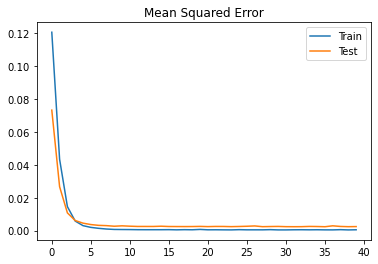

1500/1500 [==============================] - 0s 38us/step
MSE train: 0.00053, MSE test: 0.00054 MSE val: 0.00055
Training Time: 25.854641914367676


In [9]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
model_40 = evaluate_model(N_channels, file_path)

In [10]:
# filename = "30_channels_ANN_model.h5"

# with h5py.File(filename, "r") as f:
#     # List all groups
#     print("Keys: %s" % f.keys())
#     a_group_key = list(f.keys())[0]

#     # Get the data
#     data = list(f[a_group_key])
#     print(data)

In [11]:
print(model_30)
print(model_40)